# 0. Imports and Dataset Load

In [5]:
# %pip install dynamax
# %pip install git+https://github.com/probml/rebayes.git
# %pip install jax-dataloader
# %pip install jax-tqdm
# %pip install flax
# %pip install avalanche-lib
# %pip install bayesian-optimization

In [6]:
from functools import partial
from pathlib import Path
import pickle

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import trange
import jax_dataloader.core as jdl
import optax

from rebayes.low_rank_filter.lofi import LoFiParams
from demos.showdown.classification import (
    permuted_mnist as core,
    classification_train as benchmark,
    hparam_tune_clf as hpt,
)

In [39]:
data_kwargs = {
    'n_tasks': 100,
    'ntrain_per_task': 100,
    'nval_per_task': 1_000,
    'ntest_per_task': 1_000,
}

dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, fashion=True)

In [40]:
output_path = Path(Path.cwd(), 'output', 'permuted-mnist', 'experiment')
output_path.mkdir(parents=True, exist_ok=True)

In [41]:
features = [400, 400, 10]
model_dict = benchmark.init_model(type='mlp', features=features)

In [42]:
(Xtr, Ytr), (Xval, Yval), (Xte, Yte) = dataset.values()

In [43]:
# Measure in-task performance after 20 tasks
val_after = 20
X_warmup_tr = Xtr[:val_after*data_kwargs["ntrain_per_task"]]
Y_warmup_tr = Ytr[:val_after*data_kwargs["ntrain_per_task"]]
warmup_train = (X_warmup_tr, Y_warmup_tr)

X_warmup_val = Xval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
Y_warmup_val = Yval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
warmup_val = (X_warmup_val, Y_warmup_val)

In [44]:
ll_calback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)

# 1. FDEKF

## 1.1 Hyperparam Tuning

In [45]:
pbounds={
    'log_init_cov': (-10, 1),
    'log_dynamics_weights': (-50, 0),
    'log_dynamics_cov': (-50, 0),
    'log_alpha': (-50, 0),
}
fdekf_model = 'fdekf'

In [46]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'fdekf',
)

In [47]:
%%time
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -873.3    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -282.1    | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -814.4    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.284    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.412    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.99     | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.719    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -1.841    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.745    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.587    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -104.5    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -365.4    | -14.06    | 

## 1.2 Test-Set Evaluation

In [48]:
fdekf_model = 'fdekf'
fdekf_hparams = {
    'initial_covariance': 0.027148086840588965,
    'dynamics_weights': 0.9999999990377035,
    'dynamics_covariance': 1.0791385346291648e-08,
    'dynamics_covariance_inflation_factor': 6.359638985510327e-21
}

In [49]:
# fdekf_hparams = hpt.get_best_params(fdekf_optimizer, method=fdekf_model)
fdekf_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                         fdekf_hparams, model_dict['emission_mean_function'],
                                         model_dict['emission_cov_function'], 
                                         method=fdekf_model)

In [50]:
fdekf_hparams

{'initial_covariance': 0.027148086840588965,
 'dynamics_weights': 0.9999999990377035,
 'dynamics_covariance': 1.0791385346291648e-08,
 'dynamics_covariance_inflation_factor': 6.359638985510327e-21}

In [51]:
accuracy_fn = lambda logits, label: jnp.mean(logits.argmax(axis=-1) == label)
evaluate_accuracy = partial(
    benchmark.evaluate_function,
    loss_fn=accuracy_fn
)

In [52]:
def test_acc_callback(i, bel_pre_update, bel, batch, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    ntest_per_batch = kwargs["ntest_per_batch"]
    
    prev_test_batch, curr_test_batch = i*ntest_per_batch, (i+1)*ntest_per_batch
    curr_X_test, curr_y_test = X_test[prev_test_batch:curr_test_batch], y_test[prev_test_batch:curr_test_batch]
    cum_X_test, cum_y_test = X_test[:curr_test_batch], y_test[:curr_test_batch]
    
    overall_accuracy = evaluate_accuracy(bel.mean, apply_fn, cum_X_test, cum_y_test)
    current_accuracy = evaluate_accuracy(bel.mean, apply_fn, curr_X_test, curr_y_test)
    task1_accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'current': current_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [53]:
def evaluate_model(estimator, n_iter=5, bel=None):
    overall_accs, current_accs, task1_accs = [], [], []
    for i in trange(n_iter):
        # Load dataset with random permutation and random shuffle
        dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, key=i, fashion=True)
        (Xtr, Ytr), _, (Xte, Yte) = dataset.values()
        train_ds = jdl.ArrayDataset(Xtr, Ytr)
        train_loader = jdl.DataLoaderJax(
            train_ds, batch_size=data_kwargs["ntrain_per_task"], shuffle=False, drop_last=False
        )

        test_kwargs = {
            'X_test': Xte,
            'y_test': Yte,
            'ntest_per_batch': data_kwargs["ntest_per_task"],
            'apply_fn': model_dict["apply_fn"],
        }

        _, accs = estimator.scan_dataloader(
            train_loader, 
            callback=test_acc_callback, 
            bel=bel,
            callback_at_end=True,
            **test_kwargs
        )
        overall_accs.append(jnp.array([res['overall'] for res in accs]))
        current_accs.append(jnp.array([res['current'] for res in accs]))
        task1_accs.append(jnp.array([res['task1'] for res in accs]))
    
    overall_accs, current_accs, task1_accs = jnp.array(overall_accs), jnp.array(current_accs), jnp.array(task1_accs)
    overall_accs, current_accs, task1_accs = \
        overall_accs.reshape((n_iter, -1)), current_accs.reshape((n_iter, -1)), task1_accs.reshape((n_iter, -1))

    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'current': current_accs.mean(axis=0),
        'current-std': current_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0),
    }
    
    return result


In [54]:
fdekf_res = evaluate_model(fdekf_estimator)

100%|██████████| 5/5 [01:29<00:00, 17.86s/it]


In [55]:
filename = f'fdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(fdekf_res, f)

# 2. VDEKF

## 2.1 Hyperparam Tuning

In [56]:
vdekf_model = 'vdekf'

In [57]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'vdekf',
)

In [58]:
%%time
vdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -332.6    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -2.548e+0 | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -453.1    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.284    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.418    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.99     | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.719    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -1.606    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.749    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.586    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -568.8    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -323.1    | -14.06    | 

## 2.2 Test-Set Evaluation

In [59]:
vdekf_model = 'vdekf'
vdekf_hparams = {
    'initial_covariance': 0.004461548669775887,
    'dynamics_weights': 1.0,
    'dynamics_covariance': 1.1711220914355552e-06,
    'dynamics_covariance_inflation_factor': 1.1350930234602791e-12
}

In [60]:
# vdekf_hparams = hpt.get_best_params(vdekf_optimizer, method=vdekf_model)
vdekf_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                         vdekf_hparams, model_dict['emission_mean_function'],
                                         model_dict['emission_cov_function'], 
                                         method=vdekf_model)

In [61]:
vdekf_hparams

{'initial_covariance': 0.004461548669775887,
 'dynamics_weights': 1.0,
 'dynamics_covariance': 1.1711220914355552e-06,
 'dynamics_covariance_inflation_factor': 1.1350930234602791e-12}

In [62]:
vdekf_res = evaluate_model(vdekf_estimator)

100%|██████████| 5/5 [01:39<00:00, 19.92s/it]


In [63]:
filename = f'vdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(vdekf_res, f)

# 3. LoFi (Rank 1)

## 3.1 Hyperparam Tuning

In [64]:
lofi_1_params = LoFiParams(
    memory_size=1,
    diagonal_covariance=False,
)

In [65]:
lofi_1_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_1_params
)

In [66]:
%%time
lofi_1_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.89     | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -2.327    | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -2.264    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.286    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.38     | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.982    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.62     | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -2.356    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.715    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.559    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -132.1    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -467.9    | -14.06    | 

## 3.2 Test-Set Evaluation

In [67]:
# lofi_1_hparams = {
#     'initial_covariance': 0.027148086840588965,
#     'dynamics_weights': 0.9999999990377035,
#     'dynamics_covariance': 1.0791385346291648e-08,
#     'dynamics_covariance_inflation_factor': 6.359638985510327e-21
# }

In [68]:
lofi_1_hparams = hpt.get_best_params(lofi_1_optimizer, method='lofi')
lofi_1_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                          lofi_1_hparams, model_dict['emission_mean_function'],
                                          model_dict['emission_cov_function'], 
                                          method='lofi', lofi_params=lofi_1_params)

In [69]:
lofi_1_hparams

{'initial_covariance': 0.014917355424284394,
 'dynamics_weights': 1.0,
 'dynamics_covariance': 2.085722038177336e-19,
 'dynamics_covariance_inflation_factor': 4.785838684065285e-08}

In [70]:
lofi_1_res = evaluate_model(lofi_1_estimator)

100%|██████████| 5/5 [02:49<00:00, 33.91s/it]


In [71]:
filename = f'lofi_1_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_1_res, f)

# 4. LoFi (Rank 5)

## 4.1 Hyperparam Tuning

In [72]:
lofi_5_params = LoFiParams(
    memory_size=5,
    diagonal_covariance=False,
)

In [73]:
lofi_5_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_5_params
)

In [74]:
%%time
lofi_5_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.014    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -5.887    | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -2.264    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.288    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.389    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.964    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.77     | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -2.228    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.658    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.481    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -136.1    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -115.4    | -14.06    | 

## 4.2 Test-Set Evaluation

In [75]:
# lofi_5_hparams = {
#     'initial_covariance': 0.01190844207955588,
#     'dynamics_weights': 0.9999999999999972,
#     'dynamics_covariance': 1.785188667700262e-18,
#     'dynamics_covariance_inflation_factor': 5.4230760952936105e-15
# }

In [76]:
lofi_5_hparams = hpt.get_best_params(lofi_5_optimizer, method='lofi')
lofi_5_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                          lofi_5_hparams, model_dict['emission_mean_function'],
                                          model_dict['emission_cov_function'], 
                                          method='lofi', lofi_params=lofi_5_params)

In [77]:
lofi_5_hparams

{'initial_covariance': 0.014917355424284394,
 'dynamics_weights': 1.0,
 'dynamics_covariance': 2.085722038177336e-19,
 'dynamics_covariance_inflation_factor': 4.785838684065285e-08}

In [78]:
lofi_5_res = evaluate_model(lofi_5_estimator)

100%|██████████| 5/5 [03:31<00:00, 42.40s/it]


In [79]:
filename = f'lofi_5_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_5_res, f)

# 5. Lofi (Rank 20)

## 5.1 Hyperparam Tuning

In [80]:
lofi_20_params = LoFiParams(
    memory_size=20,
    diagonal_covariance=False,
)

In [81]:
lofi_20_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_20_params
)

In [82]:
%%time
lofi_20_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -5.937    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -5.01     | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -2.265    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.289    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.286    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.944    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.459    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -2.268    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.61     | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.439    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -587.9    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -7.661e+0 | -14.06    | 

## 5.2 Test-Set Evaluation

In [83]:
# lofi_20_hparams = {
#     'initial_covariance': 0.004461548669775887,
#     'dynamics_weights': 1.0,
#     'dynamics_covariance': 1.1711220914355552e-06,
#     'dynamics_covariance_inflation_factor': 1.1350930234602791e-12
# }

In [84]:
lofi_20_hparams = hpt.get_best_params(lofi_20_optimizer, method='lofi')
lofi_20_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                           lofi_20_hparams, model_dict['emission_mean_function'],
                                           model_dict['emission_cov_function'], 
                                           method='lofi', lofi_params=lofi_20_params)

In [85]:
lofi_20_hparams

{'initial_covariance': 0.010226924200664149,
 'dynamics_weights': 0.999999993136533,
 'dynamics_covariance': 4.597785528231412e-10,
 'dynamics_covariance_inflation_factor': 1.5033331350029686e-09}

In [86]:
lofi_20_res = evaluate_model(lofi_20_estimator)

100%|██████████| 5/5 [08:30<00:00, 102.04s/it]


In [87]:
filename = f'lofi_20_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_20_res, f)

# 6. LoFi (Rank 50)

## 6.1 Hyperparam Tuning

In [105]:
lofi_50_params = LoFiParams(
    memory_size=50,
    diagonal_covariance=False,
)

In [106]:
lofi_50_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_50_params
)

In [107]:
%%time
lofi_50_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -3.398    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -3.604    | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -2.265    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.289    | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.217    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -1.948    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.448    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -2.44     | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.621    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.462    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -93.65    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -204.1    | -14.06    | 

KeyboardInterrupt: ignored

## 6.2 Test-Set Evaluation

In [108]:
# lofi_50_hparams = {
# }

In [109]:
lofi_50_hparams = hpt.get_best_params(lofi_50_optimizer, method='lofi')
lofi_50_estimator, _ = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                           lofi_50_hparams, model_dict['emission_mean_function'],
                                           model_dict['emission_cov_function'], 
                                           method='lofi', lofi_params=lofi_50_params)

In [110]:
lofi_50_hparams

{'initial_covariance': 0.014917355424284394,
 'dynamics_weights': 1.0,
 'dynamics_covariance': 2.085722038177336e-19,
 'dynamics_covariance_inflation_factor': 4.785838684065285e-08}

In [111]:
lofi_50_res = evaluate_model(lofi_50_estimator)

  0%|          | 0/5 [00:36<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
filename = f'lofi_50_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_50_res, f)

# 7. Online Gradient Descent

## 7.1 Hyperparam Tuning

In [88]:
rsgd_pbounds = {
    'log_lr': (-8.0, 0.0),
}

In [89]:
ogd_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 1,
    'dim_output': 10
}

In [90]:
ogd_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', **ogd_params
)

In [91]:
%%time
ogd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -1e+08    | -0.665    |
| 2         | -1.579    | -3.292    |
| 3         | -1.656    | -5.88     |
| 4         | -2.332    | -1.734    |
| 5         | -1e+08    | -0.656    |
| 6         | -1e+08    | -1.381    |
| 7         | -2.327    | -2.176    |
| 8         | -1.688    | -5.916    |
| 9         | -1e+08    | -0.7059   |
| 10        | -1.68     | -5.914    |
| 11        | -2.307    | -1.869    |
| 12        | -1.681    | -5.908    |
| 13        | -2.14     | -7.022    |
| 14        | -1.359    | -4.912    |
| 15        | -1e+08    | -1.279    |
| 16        | -1.569    | -5.775    |
| 17        | -2.191    | -7.441    |
| 18        | -1.659    | -2.935    |
| 19        | -1.475    | -3.322    |
| 20        | -1.567    | -3.35     |
| 21        | -1.396    | -4.217    |
| 22        | -2.236    | -8.0      |
| 23        | -2.039    | -6.528    |
| 24        | -1.377    | -5.296    |
| 25        

## 7.2 Test-Set Evaluation

In [92]:
# ogd_hparams = {
#     'learning_rate': 0.00854625211430859
# }

In [93]:
ogd_hparams = hpt.get_best_params(ogd_optimizer, method='sgd')
ogd_estimator, bel = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       ogd_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='sgd', **ogd_params)

In [94]:
ogd_hparams

{'learning_rate': 0.012400885831038315}

In [95]:
ogd_res = evaluate_model(ogd_estimator, bel=bel)

100%|██████████| 5/5 [00:32<00:00,  6.54s/it]


In [96]:
filename = f'ogd_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(ogd_res, f)

# 8. SGD-RB (Rank 20)

## 8.1 Hyperparam Tuning

In [97]:
sgd_rb_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 20,
    'dim_output': 10
}

In [98]:
sgd_rb_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', **sgd_rb_params
)

In [99]:
%%time
sgd_rb_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -1e+08    | -0.665    |
| 2         | -2.443    | -3.292    |
| 3         | -0.9791   | -5.88     |
| 4         | -1e+08    | -1.734    |
| 5         | -1e+08    | -0.656    |
| 6         | -1e+08    | -1.381    |
| 7         | -1e+08    | -2.176    |
| 8         | -0.9883   | -5.916    |
| 9         | -1e+08    | -0.7059   |
| 10        | -1.006    | -5.914    |
| 11        | -1e+08    | -1.869    |
| 12        | -1.064    | -5.908    |
| 13        | -1.076    | -7.022    |
| 14        | -1.052    | -4.912    |
| 15        | -1e+08    | -1.279    |
| 16        | -1.041    | -5.775    |
| 17        | -1.104    | -7.441    |
| 18        | -1e+08    | -2.935    |
| 19        | -1e+08    | -3.322    |
| 20        | -1e+08    | -3.35     |
| 21        | -1e+08    | -3.245    |
| 22        | -1.044    | -5.821    |
| 23        | -1.06     | -7.067    |
| 24        | -1.088    | -7.392    |
| 25        

## 8.2 Test-Set Evaluation

In [100]:
# sgd_rb_hparams = {
#     'learning_rate': 0.0010013570569656284
# }

In [101]:
sgd_rb_hparams = hpt.get_best_params(sgd_rb_optimizer, method='sgd')
sgd_rb_estimator, bel = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       ogd_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='sgd', **sgd_rb_params)

In [102]:
sgd_rb_hparams

{'learning_rate': 0.00329132112556407}

In [103]:
sgd_rb_res = evaluate_model(sgd_rb_estimator, bel=bel)

100%|██████████| 5/5 [00:38<00:00,  7.75s/it]


In [104]:
filename = f'sgd_rb_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(sgd_rb_res, f)

# 9. Model Comparison

In [112]:
results = {
    'sgd-online': ogd_res,
    'sgd-rb': sgd_rb_res,
    'fdekf': fdekf_res,
    'vdekf': vdekf_res,
    'lofi-1': lofi_1_res,
    'lofi-5': lofi_5_res,
    'lofi-20': lofi_20_res,
}

In [113]:
# boundaries = [i for i in range(600, (600*10)+1, 600)]

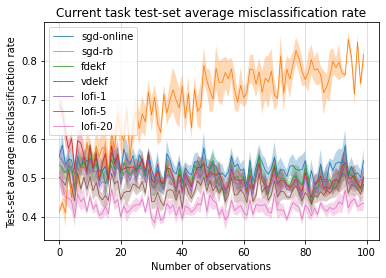

In [114]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['current'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['current'].shape[0]),
        1.0 - val['current'] - 0.5*val['current-std'],
        1.0 - val['current'] + 0.5*val['current-std'],
        alpha=0.3
    )
# Task boundaries
# for b in boundaries:
#     ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

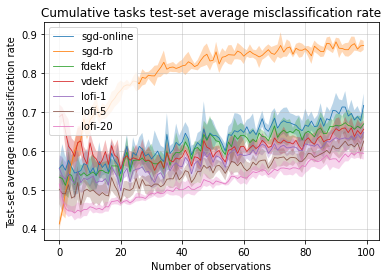

In [115]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['overall'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['overall'].shape[0]),
        1.0 - val['overall'] - val['overall-std'],
        1.0 - val['overall'] + val['overall-std'],
        alpha=0.3
    )
# Task boundaries
# for b in boundaries:
#     ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();
# fig.savefig(f'{output_path}_{name}.pdf', bbox_inches='tight')

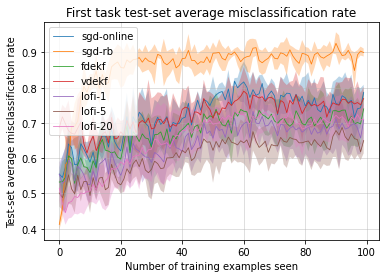

In [116]:
fig, ax = plt.subplots()
for key, val in results.items():
    ax.plot(1.0 - val['task1'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['task1'].shape[0]),
        1.0 - val['task1'] - val['task1-std'],
        1.0 - val['task1'] + val['task1-std'],
        alpha=0.3
    )
# # Task boundaries
# for b in boundaries:
#     ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'First task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();